In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
import scipy.optimize as spo
import scipy.special as sps
import math

In [2]:
#This function takes a 3d array of (size along each dimension = N_side) poisson values of lamda = n_bar and the desired
# power spectrum pk_cl and returns another 3d array of the same dimension with the n(x) following pk_cl(k)

def GonzNuevo(box_p, N_side, L_side, n_bar, pk_cl, k_for_P, pseudo_fact):
    #Now pixel size of the box
    del_x = L_side/(N_side - 1)

    #Now let's get the density contrast
    box_delx = (box_p - n_bar)/n_bar

    #Now let's take the fourier transform of box_delx to get box_delk
    box_delk = pseudo_fact * np.fft.fftn(box_delx, norm='ortho')

    temp_factor = np.power(del_x * np.sqrt(N_side)/np.sqrt(2 * np.pi), 3)
    box_delk = temp_factor * box_delk

    #Getting the corresponding k values along 1d axis
    k_vals = 2 * np.pi * np.fft.fftfreq(N_side, d=del_x) # This is removed here---- , d= del_x)    

    #Power spectrum of the Poisson field box_delx
    #First I create a 3d array of same shape as box_delk, with values equal
    #to |k| value corresponding to same position in box_delk.
    temb_mesh = np.meshgrid(k_vals, k_vals, k_vals, indexing='ij')
    modk_grid = np.sqrt(temb_mesh[0] ** 2 + temb_mesh[1] ** 2 + temb_mesh[2] ** 2)

    #Now let's iterate through the k_for_P and find the index of modk_grid with k
    #that falls between and find power spectrum pk.
    pk = np.zeros(len(k_for_P)-1)
    for i, (k1, k2) in enumerate(zip(k_for_P[:-1], k_for_P[1:])):
        pk[i] = np.average(np.absolute(box_delk[np.where((modk_grid >= k1) & (modk_grid < k2))]) ** 2)
    
    box_vol = (N_side * del_x)**3
    pk = pk/box_vol * np.power(np.sqrt(2 * np.pi), 3)

    #----------------------------------------------------------------------------------------------------
    #plotting the pks
    k_for_P_mid = (k_for_P[:-1] + k_for_P[1:])/2

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    ax1.plot(k_for_P_mid, pk)
    ax2.plot(k_for_P_mid, pk_cl)

    ax1.set_xlabel('k')
    ax1.set_ylabel(r'$P_{pois}(k)$')
    ax2.set_xlabel('k')
    ax2.set_ylabel(r'$P_{cl}(k)$')
    #----------------------------------------------------------------------------------------------------
    
    #Make a new delk.
    box_delk_new = np.copy(box_delk)

    #modify the delk using the chosen power spectrum
    for i, (k1, k2) in enumerate(zip(k_for_P[:-1], k_for_P[1:])):
        temp_ind = np.where((modk_grid >= k1) & (modk_grid < k2))
        box_delk_new[temp_ind] = box_delk[temp_ind] * (np.sqrt(pk_cl[i] + pk[i])) / np.sqrt(pk[i])

    #Now we need to inverse fourier transfor box_delk_new to get box_delx_new
    box_delx_new = pseudo_fact * np.fft.ifftn(box_delk_new, norm='ortho')
    
    #Now again we have to add the factors
    del_k = 2 * np.pi/(N_side * del_x)
    temp_factor = np.power(del_k * np.sqrt(N_side)/np.sqrt(2 * np.pi), 3)
    box_delx_new = temp_factor * box_delx_new

    #Now to get the new n(x)
    #box_GN = np.asarray(np.round(n_bar * (1 + box_delx_new)), dtype='int64')
    box_GN = box_delx_new # n_bar * (1 + box_delx_new) #np.where(box_delx_new<0, 0, box_delx_new))  #I have made all the negative values in box_delx_new to 0


    #-------------------------------------------------------------------------------------------------------
    #finding the new power spectrum
    pk_new = np.zeros(len(k_for_P)-1)
    for i, (k1, k2) in enumerate(zip(k_for_P[:-1], k_for_P[1:])):
        pk_new[i] = np.average(np.absolute(box_delk_new[np.where((modk_grid >= k1) & (modk_grid < k2))]) ** 2)
    
    pk_new = pk_new/box_vol * np.power(np.sqrt(2 * np.pi), 3)

    #plotting the new psd vs the given one
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.plot(k_for_P_mid, pk_new, label=r'$P_{new}(k)$')
    ax1.plot(k_for_P_mid, pk_cl, label=r'$P_{cl}(k)$')
    ax1.set_xlabel('k')
    ax1.set_ylabel(r'$P(k)$')
    ax1.legend()
    ax2.plot(k_for_P_mid, pk_new-pk_cl, label=r'$P_{new}(k) - P_{cl}(k)$')
    ax2.set_xlabel('k')
    ax2.legend()
    #-------------------------------------------------------------------------------------------------------

    return box_GN

In [20]:
def pow_func(r, A, alpha):
    return A * np.power(r, -alpha)

def plaw_pspec_to_2pcf(const, delta):
    alpha = 3 - delta
    A = const * (sps.gamma(alpha/2))/ (np.power(2, 1 - alpha/2) * sps.gamma((3 - alpha)/2))
    return A, alpha

def plaw_2pcf_to_pspec(A, alpha):
    delta = 3 - alpha
    const = A * (np.power(2, 1 - alpha/2) * sps.gamma((3 - alpha)/2)) / (sps.gamma(alpha/2))
    return const, delta

class clust_dist:
    def __init__(self, N_side, dx) -> None:
        self.N_side = N_side
        self.dx = dx
        #dk of the fourier lattice.
        self.dk = 2 * np.pi/(self.N_side * self.dx)

    def initialize_pois(self, n_bar):
        self.n_bar = n_bar
        
        #Creating a box with N_side^3 dimension and fill it with poisson random numbers with lambda=n_bar.
        self.box_p = np.random.poisson(lam=n_bar, size=(self.N_side, self.N_side, self.N_side))
        print("Poisson lattice is created.")
        #Density contrast.
        self.box_delx = (self.box_p - n_bar)/n_bar
        #Now taking the fourier transform of box_delx to get box_delk
        self.box_delk = np.fft.fftn(self.box_delx, norm='ortho')
        temp_factor = np.power(self.dx * np.sqrt(self.N_side)/np.sqrt(2 * np.pi), 3)
        self.box_delk = temp_factor * self.box_delk
        #Getting the corresponding k values along 1d axis and creating a 3d grid of corresponding k value
        #of the box_delk.
        temp_k_vals = 2 * np.pi * np.fft.fftfreq(self.N_side, d=self.dx)
        self.temp_k_vals =temp_k_vals
        temb_mesh = np.meshgrid(temp_k_vals, temp_k_vals, temp_k_vals, indexing='ij')
        self.modk_grid = np.sqrt(temb_mesh[0] ** 2 + temb_mesh[1] ** 2 + temb_mesh[2] ** 2)
        #Finding the minimum and maximum of k values
        self.k_min = 0
        self.k_max = 2 * np.pi/(2 * self.dx)* np.sqrt(3)
        #Finding the powerspectrum here.
        self.k_intervals = np.linspace(self.k_min, self.k_max, self.N_side//2) #default k_intervals
        self.k_intervals_mid = (self.k_intervals[:-1] + self.k_intervals[1:])/2
        self.powerspec_pois = self.calc_powerspec_pois(self.k_intervals)
        print("Poisson power spectrum calculated.")

    def initialize_gauss(self, lam, sig):
        self.n_bar = lam

        #Creating a box with N_side^3 dimension and fill it with Gaussian random numbers with lambda=lam and sigma = sig.
        self.box_p = np.random.normal(loc=lam, scale=sig, size=(self.N_side, self.N_side, self.N_side))
        print("Gaussian lattice is created.")
        #Density contrast.
        self.box_delx = (self.box_p - lam)/lam
        #Now taking the fourier transform of box_delx to get box_delk
        self.box_delk = np.fft.fftn(self.box_delx, norm='ortho')
        temp_factor = np.power(self.dx * np.sqrt(self.N_side)/np.sqrt(2 * np.pi), 3)
        self.box_delk = temp_factor * self.box_delk
        #Getting the corresponding k values along 1d axis and creating a 3d grid of corresponding k value
        #of the box_delk.
        temp_k_vals = 2 * np.pi * np.fft.fftfreq(self.N_side, d=self.dx)
        self.temp_k_vals =temp_k_vals
        temb_mesh = np.meshgrid(temp_k_vals, temp_k_vals, temp_k_vals, indexing='ij')
        self.modk_grid = np.sqrt(temb_mesh[0] ** 2 + temb_mesh[1] ** 2 + temb_mesh[2] ** 2)
        #Finding the minimum and maximum of k values
        self.k_min = 0
        self.k_max = 2 * np.pi/(2 * self.dx)* np.sqrt(3)
        #Finding the powerspectrum here.
        self.k_intervals = np.linspace(self.k_min, self.k_max, self.N_side//2) #default k_intervals
        self.k_intervals_mid = (self.k_intervals[:-1] + self.k_intervals[1:])/2
        self.powerspec_pois = self.calc_powerspec_pois(self.k_intervals)
        print("Poisson power spectrum calculated.")
    
    def calc_powerspec_pois(self, k_intervals):
        #Finding the powerspectrum here. Iterate through the k_for_P and find the index of modk_grid with k
        #that falls between and find power spectrum pk.
        powerspec = np.zeros(len(k_intervals)-1)
        for i, (k1, k2) in enumerate(zip(k_intervals[:-1], k_intervals[1:])):
            powerspec[i] = np.average(np.absolute(self.box_delk[np.where((self.modk_grid >= k1) & (self.modk_grid < k2))]) ** 2)
        powerspec = powerspec/((self.N_side * self.dx)**3) * np.power(np.sqrt(2 * np.pi), 3)

        return powerspec
    
    def update_k_intervals(self, k_intervals):
        ##Assert that the given k_intervals have appropriate k_min and k_max
        assert k_intervals[0] == self.k_min
        # assert k_intervals[-1] == self.k_max
        #updating the k_intervals
        self.k_intervals = np.copy(k_intervals)
        self.k_intervals_mid = (self.k_intervals[:-1] + self.k_intervals[1:])/2
        self.powerspec_pois = self.calc_powerspec_pois(self.k_intervals)

    def make_clust_dist(self, powerspec_clust, k_intervals):
        #Making the new box_delk_clust. Right now, whenever we call this method, the previous box_delk_clust if any
        #will be erased.
        self.box_delk_clust = np.copy(self.box_delk)
        #Modifying the box-delk_clust to have the input powerspectrum.
        for i, (k1, k2) in enumerate(zip(k_intervals[:-1], k_intervals[1:])):
            temp_ind = np.where((self.modk_grid >= k1) & (self.modk_grid < k2))
            self.box_delk_clust[temp_ind] = self.box_delk[temp_ind] * (np.sqrt(powerspec_clust[i] + self.powerspec_pois[i])) / np.sqrt(self.powerspec_pois[i])
        #Defining the input powerspec as the powerspec of box_delk_clust
        self.powerspec_clust = np.copy(powerspec_clust)
        self.update_k_intervals(k_intervals)
        #Now we need to inverse fourier transfor box_delk_clust to get box_delx_clust
        self.box_delx_clust = np.fft.ifftn(self.box_delk_clust, norm='ortho')
        temp_factor = np.power(self.dk * np.sqrt(self.N_side)/np.sqrt(2 * np.pi), 3)
        self.box_delx_clust = temp_factor * self.box_delx_clust
        #Create the new n(x) array.
        self.box_GN = self.n_bar * (1 + self.box_delx_clust)
        print("Made the clustered distribution.")

    def make_clust_dist_from_plaw_pspec(self, const, delta, k_intervals):
        temp_pk = const * np.power(self.k_intervals_mid, -delta)
        self.make_clust_dist(temp_pk, k_intervals) 

    def calc_2pcorrfunc_clust(self, x_min, x_max):
        assert x_min > 0
        assert x_max > x_min
        # assert issubclass(x_intervals_int.dtype.int, np.integer)
        # min and max integer between given interval
        x_min_int = math.ceil(x_min/self.dx)
        x_max_int = math.ceil(x_max/self.dx)
        #defining the x intervals in which we calculate the 2pcf
        self.x_intervals_mid = np.arange(x_min_int, x_max_int) * self.dx #I chose only even
        self._2pcorrfunc = np.zeros_like(self.x_intervals_mid)
        for i, temp_x in enumerate(np.arange(x_min_int, x_max_int)):
            self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)
        print("2 point correlation function calculated.")

    def calc_2pcorrfunc_clust2(self, x_min, x_max):
        assert x_min > 0
        assert x_max > x_min
        # assert issubclass(x_intervals_int.dtype.int, np.integer)
        # min and max integer between given interval
        x_min_int = math.ceil(x_min/self.dx)
        x_max_int = math.ceil(x_max/self.dx)

        box_r = np.random.poisson(lam=self.n_bar, size=(self.N_side, self.N_side, self.N_side))
        bins = np.arange(x_min_int, x_max_int)
        self.x_intervals_mid = (bins[:-1] + bins[1:])/2 * self.dx
        x1, y1, z1 = np.asarray(np.meshgrid(np.arange(self.N_side), np.arange(self.N_side), np.arange(self.N_side), indexing='xy'), dtype='float')
        x1 = x1.flatten()
        y1 = y1.flatten()
        z1 = z1.flatten()
        weights1 = np.asarray(self.box_GN.flatten(), dtype='float')

        result_DD_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, weight_type='pair_product', periodic=False, output_ravg=True)

        weights2 = np.asarray(box_r.flatten(), dtype='float')
        x_r, y_r, z_r = np.asarray(np.meshgrid(np.arange(self.N_side), np.arange(self.N_side), np.arange(self.N_side), indexing='xy'), dtype='float')
        x_r = x_r.flatten()
        y_r = y_r.flatten()
        z_r = z_r.flatten()
        result_RR_GN = DD(autocorr=1, nthreads=1, binfile=bins, X1 = x_r, Y1 = y_r, Z1 = z_r, weights1 = weights2, weight_type='pair_product', periodic=False, output_ravg=True)

        result_DR_GN = DD(autocorr=0, nthreads=1, binfile=bins, X1 = x1, Y1 = y1, Z1 = z1, weights1=weights1, X2 = x_r, Y2 = y_r, Z2 = z_r, weights2 = weights2, \
               weight_type='pair_product', periodic=False, output_ravg=True)
        #Now with DD, RR and DR that we obtained, we will find the xi(r), two point correlation function.
        #We need normalisation also, which is the total number of pairs.
        DD_count_GN = (result_DD_GN['npairs']*result_DD_GN['weightavg'])/2
        DR_count_GN = result_DR_GN['npairs']*result_DR_GN['weightavg']
        RR_count_GN = (result_RR_GN['npairs']*result_RR_GN['weightavg'])/2
        DD_total_GN = (np.sum(weights1) * (np.sum(weights1) - 1))/2
        RR_total_GN = (np.sum(weights2) * (np.sum(weights2) - 1))/2
        DR_total_GN = (np.sum(weights1) * np.sum(weights2))

        self._2pcorrfunc = (DD_count_GN/DD_total_GN - 2 * DR_count_GN/DR_total_GN + RR_count_GN/RR_total_GN)/(RR_count_GN/RR_total_GN)


    def fit_2pcf_clust(self):
        temp_popt, temp_pcov = spo.curve_fit(pow_func, self.x_intervals_mid, self._2pcorrfunc)
        self._2pcf_fit_alpha = temp_popt[1]
        self._2pcf_fit_A = temp_popt[0]
        print("The measured 2pcf of box_delx_clust is fitted to a power law")

    def show_delx_dist(self):
        fig, ax = plt.subplots()
        ax.hist((self.box_delx_clust).flatten(), bins=100)
        ax.hist((self.box_delx).flatten(), bins=100)
        return fig, ax
    

In [81]:
N_side = 512
dx = 0.05
n_bar = 50
const_of_pk = 2.0
delta_of_pk = 1.0

sample_clust = clust_dist(N_side, dx)
sample_clust.initilize_pois(n_bar)

sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals) 

sample_clust.calc_2pcorrfunc_clust(1.0 * dx, 15 * dx)

sample_clust.fit_2pcf_clust()

exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcorrfunc, '*', label="Measured 2pcf of box_delx_clust")
plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcf_fit_A * np.power(sample_clust.x_intervals_mid, -sample_clust._2pcf_fit_alpha), \
                label=r"Plaw fit: $A = {}$, $\alpha = {}$".format(np.round(sample_clust._2pcf_fit_A,3), np.round(sample_clust._2pcf_fit_alpha,3)))
plt.plot(sample_clust.x_intervals_mid, exp_A * np.power(sample_clust.x_intervals_mid, -exp_alpha), \
            label=r"Expected: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
# plt.xscale('log')
# plt.yscale('log')
plt.legend()

KeyboardInterrupt: 

## Tests happen here

Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.


/tmp/ipykernel_25573/3410132560.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)


2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law


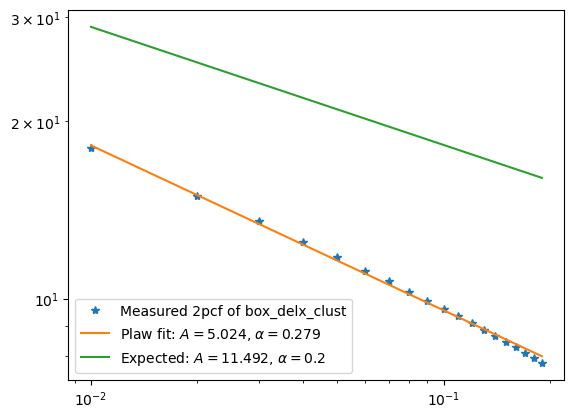

In [35]:
N_side = 512
dx = 0.01
n_bar = 50
const_of_pk = 2.0
delta_of_pk = 2.8

sample_clust = clust_dist(N_side, dx)
sample_clust.initialize_pois(n_bar)
# print(sample_clust.k_intervals)
# new_k_intervals = np.concatenate((np.linspace(sample_clust.k_min, (sample_clust.k_max)/2, N_side//4), np.linspace((sample_clust.k_max)/2, sample_clust.k_max, N_side//2)))
# new_k_intervals = np.linspace(sample_clust.k_min, sample_clust.k_max, N_side)
# sample_clust.update_k_intervals(new_k_intervals)
# print(sample_clust.k_intervals)

sample_clust.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust.k_intervals) 

sample_clust.calc_2pcorrfunc_clust(1 * dx, 20 * dx)

sample_clust.fit_2pcf_clust()

exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcorrfunc, '*', label="Measured 2pcf of box_delx_clust")
plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcf_fit_A * np.power(sample_clust.x_intervals_mid, -sample_clust._2pcf_fit_alpha), \
                label=r"Plaw fit: $A = {}$, $\alpha = {}$".format(np.round(sample_clust._2pcf_fit_A,3), np.round(sample_clust._2pcf_fit_alpha,3)))
plt.plot(sample_clust.x_intervals_mid, exp_A * np.power(sample_clust.x_intervals_mid, -exp_alpha), \
            label=r"Expected: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [26]:
def calc_2pcorrfunc_clust3(self, x_min, x_max):
    assert x_min > 0
    assert x_max > x_min
    # assert issubclass(x_intervals_int.dtype.int, np.integer)
    # min and max integer between given interval
    x_min_int = math.ceil(x_min/self.dx)
    x_max_int = math.ceil(x_max/self.dx)
    #defining the x intervals in which we calculate the 2pcf
    self.x_intervals_mid = np.arange(x_min_int, x_max_int) * self.dx
    self._2pcorrfunc = np.zeros_like(self.x_intervals_mid)
    for i, temp_x in enumerate(np.arange(x_min_int, x_max_int)):
        self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:,:self.N_side-temp_x,:]) * (self.box_delx_clust[:, temp_x:,:]))/ (self.N_side** 3)
    print("2 point correlation function calculated.")

/tmp/ipykernel_25573/2389657203.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:,:self.N_side-temp_x,:]) * (self.box_delx_clust[:, temp_x:,:]))/ (self.N_side** 3)


2 point correlation function calculated.
The measured 2pcf of box_delx_clust is fitted to a power law


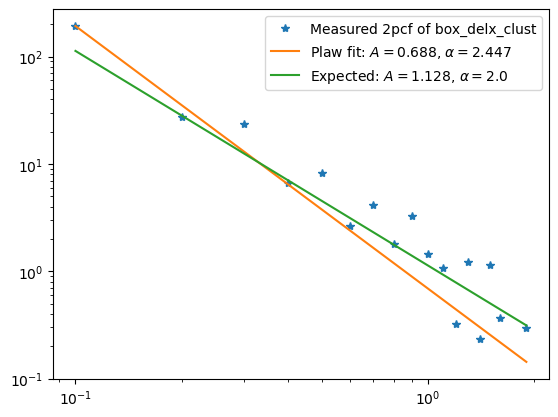

In [27]:
calc_2pcorrfunc_clust3(sample_clust, 1 * dx, 20 * dx)

sample_clust.fit_2pcf_clust()

exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcorrfunc, '*', label="Measured 2pcf of box_delx_clust")
plt.plot(sample_clust.x_intervals_mid, sample_clust._2pcf_fit_A * np.power(sample_clust.x_intervals_mid, -sample_clust._2pcf_fit_alpha), \
                label=r"Plaw fit: $A = {}$, $\alpha = {}$".format(np.round(sample_clust._2pcf_fit_A,3), np.round(sample_clust._2pcf_fit_alpha,3)))
plt.plot(sample_clust.x_intervals_mid, exp_A * np.power(sample_clust.x_intervals_mid, -exp_alpha), \
            label=r"Expected: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
plt.xscale('log')
plt.yscale('log')
plt.legend()

Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.


/tmp/ipykernel_2247003/1946390989.py:97: ComplexWarning: Casting complex values to real discards the imaginary part
  self._2pcorrfunc[i] = np.sum((self.box_delx_clust[:self.N_side-temp_x,:,:]) * (self.box_delx_clust[temp_x:,:,:]))/ (self.N_side** 3)


Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.
Poisson power spectrum calculated.
Made the clustered distribution.
2 point correlation function calculated.
Poisson lattice is created.
Poisson power spectrum calculated.
Made t

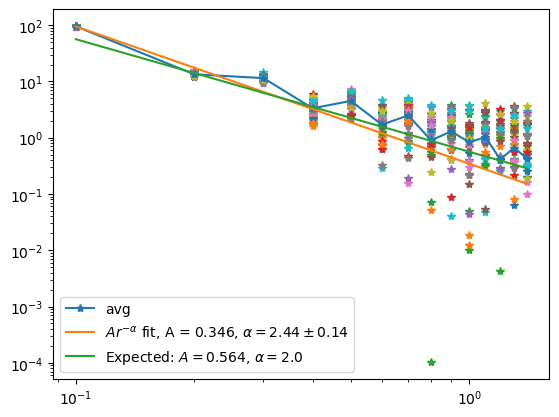

In [125]:
N_side = 64
dx = 0.1
n_bar = 50
const_of_pk = 1.0
delta_of_pk = 1.0
x_min = 1.0 * dx
x_max = 15.0 * dx
iter_n = 50

temp_corr = np.zeros((iter_n, len(np.arange(math.ceil(x_min/dx), math.ceil(x_max/dx)))))
for i in range(iter_n):
    sample_clust_32 = clust_dist(N_side, dx, n_bar)

    sample_clust_32.make_clust_dist_from_plaw_pspec(const_of_pk, delta_of_pk, sample_clust_32.k_intervals)

    sample_clust_32.calc_2pcorrfunc_clust(x_min, x_max)

    temp_corr[i] = sample_clust_32._2pcorrfunc
    plt.plot(sample_clust_32.x_intervals_mid, temp_corr[i], '*')

temp_corr_avg = np.average(temp_corr, axis=0)
plt.plot(sample_clust_32.x_intervals_mid, temp_corr_avg, '-*', label="avg")

temp_popt, temp_pcov = spo.curve_fit(pow_func, sample_clust_32.x_intervals_mid, temp_corr_avg)

plt.plot(sample_clust_32.x_intervals_mid, pow_func(sample_clust_32.x_intervals_mid, temp_popt[0], temp_popt[1]), label=r'$Ar^{{-\alpha}}$ fit, A = {}, $\alpha = {}\pm{}$'.format \
         (np.round(temp_popt[0],3), np.round(temp_popt[1],3),np.round(np.sqrt(temp_pcov[1,1]), 2)))

# sample_clust_32.fit_2pcf_clust()

exp_A, exp_alpha = plaw_pspec_to_2pcf(const_of_pk, delta_of_pk)

# plt.plot(sample_clust_32.x_intervals_mid, sample_clust_32._2pcorrfunc, '*', label="Measured 2pcf of box_delx_clust")
# plt.plot(sample_clust_32.x_intervals_mid, sample_clust_32._2pcf_fit_A * np.power(sample_clust_32.x_intervals_mid, -sample_clust_32._2pcf_fit_alpha), \
#                 label=r"Plaw fit: $A = {}$, $\alpha = {}$".format(np.round(sample_clust_32._2pcf_fit_A,3), np.round(sample_clust_32._2pcf_fit_alpha,3)))
plt.plot(sample_clust_32.x_intervals_mid, exp_A * np.power(sample_clust_32.x_intervals_mid, -exp_alpha), \
             label=r"Expected: $A = {}$, $\alpha = {}$".format(np.round(exp_A,3), np.round(exp_alpha,3)))
plt.xscale('log')
plt.yscale('log')
plt.legend()

## alpha delta relation

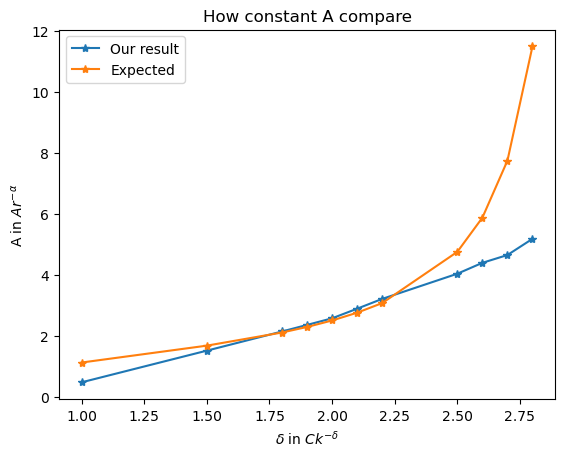

In [41]:
temp_delta = [1.0, 1.5, 1.8, 1.9, 2.0, 2.1, 2.2, 2.5, 2.6, 2.7, 2.8]
temp_A = [0.48, 1.518, 2.146, 2.361, 2.578, 2.893, 3.214, 4.039, 4.396, 4.652, 5.183]
temp_alpha = [2.463, 1.624, 1.239, 1.121, 1.008, 0.889, 0.777, 0.508, 0.429, 0.369, 0.298]
temp_A_exp, temp_alpha_exp = np.vectorize(plaw_pspec_to_2pcf)(2.0, temp_delta)
plt.plot(temp_delta, temp_A, '-*', label="Our result")
plt.plot(temp_delta, temp_A_exp, '-*', label="Expected")
plt.ylabel(r"A in $Ar^{-\alpha}$")
plt.xlabel(r"$\delta$ in $Ck^{-\delta}$")
plt.title("How constant A compare")
plt.legend()

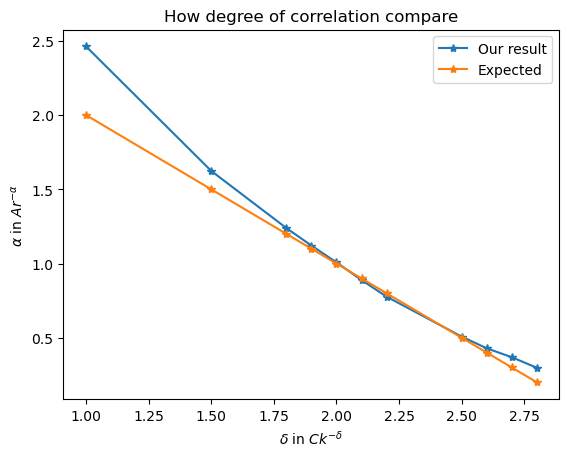

In [43]:
plt.plot(temp_delta, temp_alpha, '-*', label="Our result")
plt.plot(temp_delta, temp_alpha_exp, '-*', label="Expected")
plt.ylabel(r"$\alpha$ in $Ar^{-\alpha}$")
plt.xlabel(r"$\delta$ in $Ck^{-\delta}$")
plt.title("How degree of correlation compare")
plt.legend()